In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

import SCRBenchmark.SRSDFeynman as srsdf
from SCRBenchmark import Benchmark

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=UserWarning)

def reportConstraintViolation(valid,constraints):
    if(valid):
        print("No Constraint Violated")
    else:
        violation = [ f"Id: {c['id']} VarName: {c['var_name']}" for c in constraints]
        print(f"Violated the constraints: {violation}")

# Checking Constraints

## Analyzing the original equation
Equation I.6.20, with 

$f(\sigma, \theta) = \frac{1}{\sigma\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{\theta}{\sigma}\right)^{\!2}\,\right)$

is the probabilistic density function of the normal distribution. 
We can analyze the contour plot of this function to determine possible constraints.

C:\Users\P41874\AppData\Local\Temp\ipykernel_24044\4169947372.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


Text(0, 0.5, 'sigma')

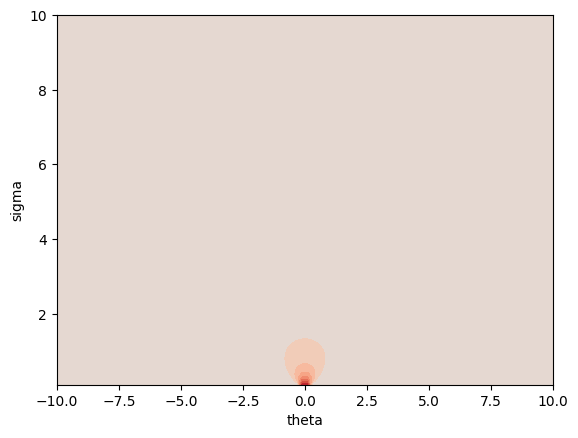

In [2]:
ICh6Eq20 = Benchmark(srsdf.FeynmanICh6Eq20)

xlist = np.linspace(-10,10, 100) # the valid range of theta for ICh6Eq20 (except for [-0.1,0.1])
ylist = np.linspace(0.1, 10, 100) # the valid range of sigma for ICh6Eq20
X, Y = np.meshgrid(xlist, ylist)

grid_z_pos = ICh6Eq20.equation.calculate((X,Y))

norm = Normalize( vmin=-np.max(grid_z_pos), vmax=np.max(grid_z_pos))
cmap = cm.get_cmap('coolwarm')

ax = plt.subplot()
plt.contourf(X, Y, grid_z_pos, cmap= cmap , norm= norm)
ax.set_xlabel('theta')
ax.set_ylabel('sigma')


If we _zoom in_ to theta [-1,1] and sigma [0.1,1.5] we can see the effect more clearly:

C:\Users\P41874\AppData\Local\Temp\ipykernel_24044\3673716121.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


(0.1, 1.5)

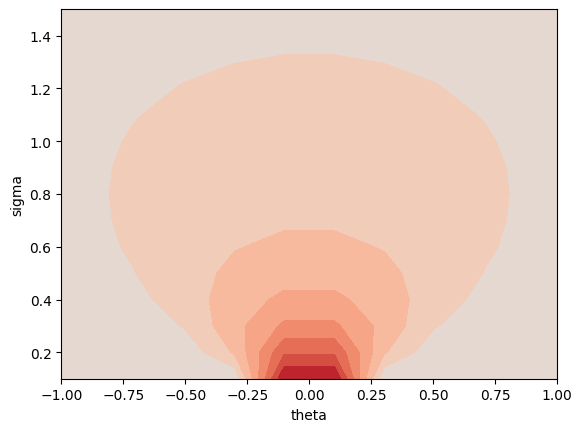

In [3]:
ICh6Eq20 = Benchmark(srsdf.FeynmanICh6Eq20)

xlist = np.linspace(-10,10, 100) # the valid range of theta for ICh6Eq20 (except for [-0.1,0.1])
ylist = np.linspace(0.1, 10, 100) # the valid range of sigma for ICh6Eq20
X, Y = np.meshgrid(xlist, ylist)

grid_z_pos = ICh6Eq20.equation.calculate((X,Y))

norm = Normalize( vmin=-np.max(grid_z_pos), vmax=np.max(grid_z_pos))
cmap = cm.get_cmap('coolwarm')

ax = plt.subplot()
plt.contourf(X, Y, grid_z_pos, cmap= cmap , norm= norm)
ax.set_xlabel('theta')
ax.set_ylabel('sigma')
ax.set_xlim([-1,1])
ax.set_ylim([0.1,1.5])


We can see that, if we hold sigma constant for any of its values, theta is monotonic increasing in theta<0 and monotonic decreasing in theta>0. This can also be determined algorithmically for any given equation. 

## Determine constraints algorithmically
The constraints can be determined algorithmically by:

1. Calculating the partial derivatives of the function for each input using SymPy. 
1. Sampling a uniform dataset for all interesting _subdomains_ of our input space. 
    1. For ICh6Eq20 e.g., sampling for sigma is defined as ` DefaultSampling(1.0e-1, 1.0e1, uses_negative=False)` so [0.1,10] with a skew towards 0.1. Whereas, theta is defined as `DefaultSampling(1.0e-1, 1.0e1)` resulting in a concated [-10,-0.1] and [0.1,10] with a higher density at the joint (see `./examples/generate_data.ipynb` for more details).
    1. Therefore, we split theta into positive and negative values and investigate the two quadrants `sigma,theta in [0.1,10]x[0.1,10]` and `sigma,theta in [0.1,10]x[-10,-0.1]` separately.
    1. This step is repeated until all inputs, where positive and negative values are sampled, are split into two areas.
1. We iterate over all sample subspaces and over all partial derivatives and calculate the gradient.
1. If all values are e.g. positive, then the function is monotonically decreasing over the variable used for the partial derivative in the sampled subspace.

This results in the following constraints for ICh6Eq20:
```json
 "Constraints": [
  {
    "var_display_name": "theta",
    "order_derivative": 1,
    "descriptor": "monotonic decreasing",
    "derivative": "-sqrt(2)*x0*exp(-x0**2/(2*x1**2))/(2*sqrt(pi)*x1**3)",
    "sample_space": [{
        "name": "x0",
        "low": 0.1,
        "high": 10.0
      },{
        "name": "x1",
        "low": 0.1,
        "high": 10.0
      }],},
  {
    "var_display_name": "theta",
    "order_derivative": 1,
    "descriptor": "monotonic increasing",
    "derivative": "-sqrt(2)*x0*exp(-x0**2/(2*x1**2))/(2*sqrt(pi)*x1**3)",
    "sample_space": [{
        "name": "x0",
        "low": -10.0,
        "high": -0.1
      },{
        "name": "x1",
        "low": 0.1,
        "high": 10.0
      }],}
]
```

**cf. `./generate/1-sample_constraints.py` for details.**

## Check constraints for a given function

Checking constraints for a provided function is implemented similarly to the determination of constraints for the original equation function. However, as we know all available constraints and their respective input space for which they apply, we create only those subspaces for which we have constraints available.

The following example illustrates functionality of our `benchmark.check_constraints`

### potential solutions: $-(theta*theta)$ and $(theta*theta)$
The following contour plot should visualize that this $-(theta*theta)$ (is a very bad fit for data sampled from ICh6Eq20) but does fit our available constraints. Whereas, $(theta*theta)$ violates both available constraints

C:\Users\P41874\AppData\Local\Temp\ipykernel_24044\4134057410.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


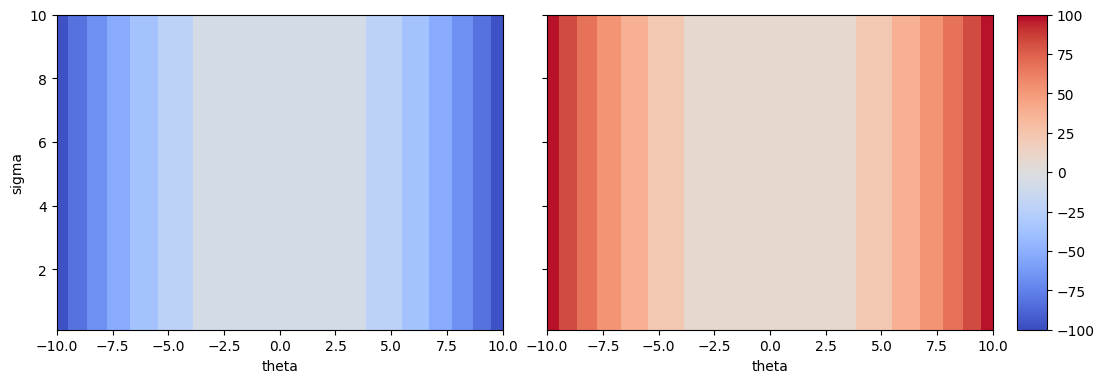

In [4]:
ist = np.linspace(-10,10, 100) # the valid range of theta for ICh6Eq20 (except for [-0.1,0.1])
ylist = np.linspace(0.1, 10, 100) # the valid range of sigma for ICh6Eq20
X, Y = np.meshgrid(xlist, ylist)

def f1(theta,sigma):
    return -(theta*theta)
def f2(theta,sigma):
    return (theta*theta)

grid_z_pos1 = f1(X,Y)
grid_z_pos2 = f2(X,Y)

fig, ax = plt.subplots(1,2, figsize=(12,5),  sharey=True)
norm = Normalize( vmin=np.min([np.min(grid_z_pos1), np.min(grid_z_pos2)]), 
                  vmax=np.max([np.max(grid_z_pos1), np.max(grid_z_pos2)]))
cmap = cm.get_cmap('coolwarm')

ax[0].contourf(X, Y, grid_z_pos1, cmap= cmap , norm= norm)
ax[1].contourf(X, Y, grid_z_pos2, cmap= cmap , norm= norm)
ax[0].set_xlabel('theta')
ax[1].set_xlabel('theta')
ax[0].set_ylabel('sigma')

plt.subplots_adjust(left=0.09, bottom=0.22, right=0.87, top=0.85, wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([.89, .22, .025, .63])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax = cbar_ax)

In [5]:
(valid, constraints) = ICh6Eq20.check_constraints("-(theta*theta)",use_display_names=True)
reportConstraintViolation(valid, constraints)

Violated the constraints: ['Id: 0 VarName: ']


In [6]:
(valid, constraints) = ICh6Eq20.check_constraints("(theta*theta)",use_display_names=True)
reportConstraintViolation(valid, constraints)

Violated the constraints: ['Id: 1 VarName: x0', 'Id: 2 VarName: x0']


### potential solutions: $theta$ and $-theta$
Are both constructed to violate only one constraint. Therefore, our interface returns false and lists only the one violated constraint in its full definition.

C:\Users\P41874\AppData\Local\Temp\ipykernel_24044\1609007540.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


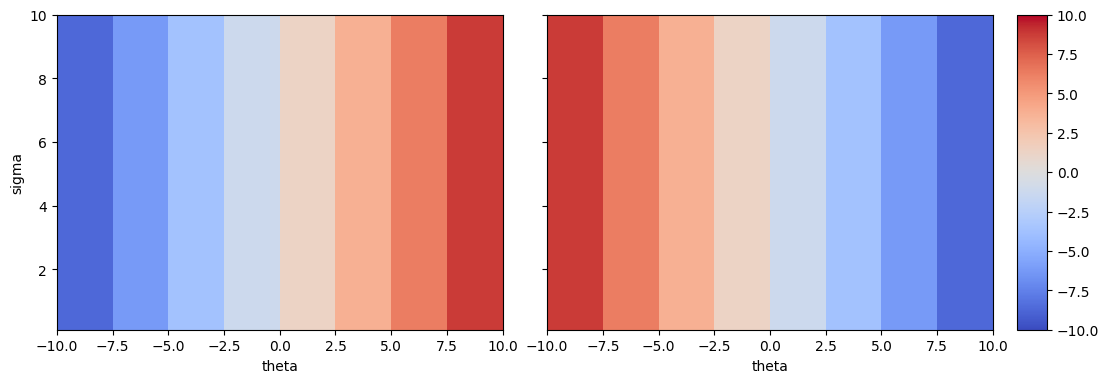

In [7]:
ist = np.linspace(-10,10, 100) # the valid range of theta for ICh6Eq20 (except for [-0.1,0.1])
ylist = np.linspace(0.1, 10, 100) # the valid range of sigma for ICh6Eq20
X, Y = np.meshgrid(xlist, ylist)

def f1(theta,sigma):
    return theta
def f2(theta,sigma):
    return -theta
grid_z_pos1 = f1(X,Y)
grid_z_pos2 = f2(X,Y)

fig, ax = plt.subplots(1,2, figsize=(12,5),  sharey=True)
norm = Normalize( vmin=np.min([np.min(grid_z_pos1), np.min(grid_z_pos2)]), 
                  vmax=np.max([np.max(grid_z_pos1), np.max(grid_z_pos2)]))
cmap = cm.get_cmap('coolwarm')

ax[0].contourf(X, Y, grid_z_pos1, cmap= cmap , norm= norm)
ax[1].contourf(X, Y, grid_z_pos2, cmap= cmap , norm= norm)
ax[0].set_xlabel('theta')
ax[1].set_xlabel('theta')
ax[0].set_ylabel('sigma')

plt.subplots_adjust(left=0.09, bottom=0.22, right=0.87, top=0.85, wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([.89, .22, .025, .63])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax = cbar_ax)

In [8]:
(valid, constraints) = ICh6Eq20.check_constraints("theta",use_display_names=True)
reportConstraintViolation(valid, constraints)

Violated the constraints: ['Id: 0 VarName: ', 'Id: 2 VarName: x0']


In [9]:
(valid, constraints) = ICh6Eq20.check_constraints("-theta",use_display_names=True)
reportConstraintViolation(valid, constraints)

Violated the constraints: ['Id: 0 VarName: ', 'Id: 1 VarName: x0']


## Alternative usages and variable names
The examples above utilize the human-readable display names of the equations. Instead, we can also use the numbered inputs and interchange functionality freely.

In [10]:
ICh6Eq20 = Benchmark(srsdf.FeynmanICh6Eq20)
# Raw: exp(-(theta / sigma) ** 2 / 2) / (sqrt(2 * pi) * sigma)
# is monotonic increasing over theta in -inf. <= theta <= 0
# is monotonic decreasing over theta in 0 <= theta <= inf.

############################################
#use the short variable names of SRSDFeynman
############################################

#prints true as no constraint is violated
reportConstraintViolation(*ICh6Eq20.check_constraints("-(x0*x0)"))

#prints false as the decreasing constraint for 0 <= theta <= inf. is violated
reportConstraintViolation(*ICh6Eq20.check_constraints("x0"))

#prints false as the increasing constraint for -inf. <= theta <= 0 is violated
reportConstraintViolation(*ICh6Eq20.check_constraints("-x0"))

#prints false as both constraints for x0 (theta) are violated
reportConstraintViolation(*ICh6Eq20.check_constraints("(x0*x0)"))

ICh6Eq20 = Benchmark(srsdf.FeynmanICh6Eq20, initialize_constraint_checking_datasets = False)
########################################################################
# test the same function, expect the same outputs, but use display names
########################################################################
#prints true as no constraint is violated
reportConstraintViolation(*ICh6Eq20.check_constraints("-(theta*theta)",use_display_names=True))

#prints false as the decreasing constraint for 0 <= theta <= inf. is violated
reportConstraintViolation(*ICh6Eq20.check_constraints("theta",use_display_names=True))

#prints false as the increasing constraint for -inf. <= theta <= 0 is violated
reportConstraintViolation(*ICh6Eq20.check_constraints("-theta",use_display_names=True))

#prints false as both constraints for x0 (theta) are violated
reportConstraintViolation(*ICh6Eq20.check_constraints("(theta*theta)",use_display_names=True))

Violated the constraints: ['Id: 0 VarName: ']
Violated the constraints: ['Id: 0 VarName: ', 'Id: 2 VarName: x0']
Violated the constraints: ['Id: 0 VarName: ', 'Id: 1 VarName: x0']
Violated the constraints: ['Id: 1 VarName: x0', 'Id: 2 VarName: x0']
Violated the constraints: ['Id: 0 VarName: ']
Violated the constraints: ['Id: 0 VarName: ', 'Id: 2 VarName: x0']
Violated the constraints: ['Id: 0 VarName: ', 'Id: 1 VarName: x0']
Violated the constraints: ['Id: 1 VarName: x0', 'Id: 2 VarName: x0']
